In [2]:
#import packages
import numpy as np
import pylab as pl
from os.path import join as pjoin
from mvpa2.datasets import mri
from mvpa2.misc import io as mvpaio

In [3]:
# initialize data
# projectDir="D:\\fmri\\LanguageMVPA"
# codeDir="D:\GitHub\LanguageMVPA\multivariate\python"
mask = "grayMatter"
constrasts = ["verb", "syntax", "anim", "stimtype"]
con = "syntax"

projectDir = "/Users/njchiang/Desktop/UCLA/scratchpad/LanguageMVPA" 
codeDir = "/Users/njchiang/GitHub/LanguageMVPA/multivariate/python"
betaPath = pjoin(projectDir, "betas")
maskPath = pjoin(projectDir, "masks", "sub")
labelPath = pjoin(codeDir, "labels")
attr = mvpaio.SampleAttributes(pjoin(labelPath, str(con + "_attribute_labels.txt")))

In [4]:
# load data
sub = "LMVPA006"
bSeriesName = str(sub + "_LSA_Series.nii.gz")
maskName = str(sub+"_"+mask+".nii.gz")
bSeries = pjoin(betaPath, bSeriesName)
maskFile = pjoin(maskPath, maskName)


ds = mri.fmri_dataset(samples=bSeries, 
                      targets=attr.targets, 
                      chunks=attr.chunks, 
                      mask=maskFile)
ds = ds[0:32]

 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [5]:
# little helper function to plot dissimilarity matrices
%matplotlib inline
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0,1))
    pl.colorbar()

In [6]:
# compute a dataset with the mean samples for all conditions
from mvpa2.mappers.fx import mean_group_sample
mtgs = mean_group_sample(['targets'])
mtds = mtgs(ds)

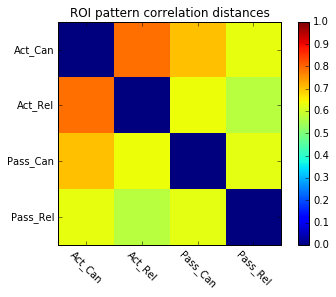

In [8]:
# basic ROI RSA -- dissimilarity matrix for the entire ROI
from mvpa2.measures import rsa
dsm = rsa.PDist(square=True)
res = dsm(mtds)
plot_mtx(res, mtds.sa.targets, 'ROI pattern correlation distances')

In [14]:
# same as above, but done in a searchlight fashion
from mvpa2.measures.searchlight import sphere_searchlight
dsm = rsa.PDist(square=False)

sl = sphere_searchlight(dsm, radius=3, nproc=1)
slres = sl(mtds)

Most dissimilar patterns around [51 14 15]


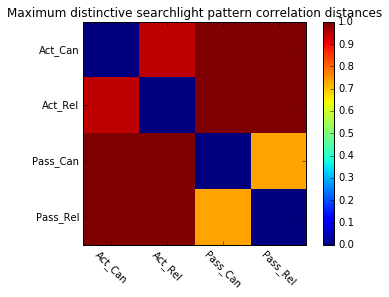

In [15]:
# score each searchlight sphere result wrt global pattern dissimilarity
distinctiveness = np.sum(np.abs(slres), axis=0)
print 'Most dissimilar patterns around', \
        mtds.fa.voxel_indices[distinctiveness.argmax()]
# take a look at the this dissimilarity structure
from scipy.spatial.distance import squareform
plot_mtx(squareform(slres.samples[:, distinctiveness.argmax()]),
         mtds.sa.targets,
         'Maximum distinctive searchlight pattern correlation distances')

In [16]:
# more interesting: let's look at the stability of similarity sturctures
# across experiment runs
# mean condition samples, as before, but now individually for each run
mtcgs = mean_group_sample(['targets', 'chunks'])
mtcds = mtcgs(ds)

In [18]:
# searchlight consistency measure -- how correlated are the structures
# across runs
dscm = rsa.PDistConsistency()
sl_cons = sphere_searchlight(dscm, radius=3, nproc=1)
slres_cons = sl_cons(mtcds)

Most stable dissimilarity patterns around [46 27  7]


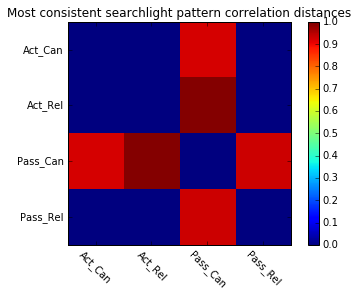

In [19]:
# mean correlation
mean_consistency = np.mean(slres_cons, axis=0)
print 'Most stable dissimilarity patterns around', \
        mtds.fa.voxel_indices[mean_consistency.argmax()]
# Look at this pattern
plot_mtx(squareform(slres.samples[:, mean_consistency.argmax()]),
         mtds.sa.targets,
         'Most consistent searchlight pattern correlation distances')

In [20]:
# let's see where in the brain we find dissimilarity structures that are
# similar to our most stable one
tdsm = rsa.PDistTargetSimilarity(
            slres.samples[:, mean_consistency.argmax()])
# using a searchlight
from mvpa2.base.learner import ChainLearner
from mvpa2.mappers.shape import TransposeMapper
sl_tdsm = sphere_searchlight(ChainLearner([tdsm, TransposeMapper()]), radius=3, nproc=1)
slres_tdsm = sl_tdsm(mtds)

In [23]:
outPath = projectDir
mri.map2nifti(ds, slres).to_filename(pjoin(outPath, sub+'_' + con + 'slres.nii.gz'))
mri.map2nifti(ds, slres_cons).to_filename(pjoin(outPath, sub+'_' + con + 'slres_cons.nii.gz'))
mri.map2nifti(ds, slres_tdsm).to_filename(pjoin(outPath, sub+'_' + con + 'slres_tdsm.nii.gz'))

In [ ]:
"""
# plot the spatial distribution using NiPy
vol = ds.a.mapper.reverse1(slres_tdsm.samples[0])
import nibabel as nb
anat = nb.load(pjoin(datapath, 'sub001', 'anatomy', 'highres001.nii.gz'))

from nipy.labs.viz_tools.activation_maps import plot_map
pl.figure(figsize=(15,4))
sp = pl.subplot(121)
pl.title('Distribution of target similarity structure correlation')
slices = plot_map(
            vol,
            ds.a.imgaffine,
            cut_coords=np.array((12,-42,-20)),
            threshold=.5,
            cmap="bwr",
            vmin=0,
            vmax=1.,
            axes=sp,
            anat=anat.get_data(),
            anat_affine=anat.get_affine(),
         )
img = pl.gca().get_images()[1]
cax = pl.axes([.05, .05, .05, .9])
pl.colorbar(img, cax=cax)

sp = pl.subplot(122)
pl.hist(slres_tdsm.samples[0],
        #range=(0,410),
        normed=False,
        bins=30,
        color='0.6')
pl.ylabel("Number of voxels")
pl.xlabel("Target similarity structure correlation") """